# ***Setting up environment***


In [30]:

!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

In [31]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
pd.read_csv('C:/Users/zaidk/Downloads/COVID-19-Risk-Prediction-main/COVID-19-Risk-Prediction-main/Machine Learning/Dataset/Covid Data - clean.csv')

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,2,1,9999-99-99,97,2,40,97,2,...,2,2,2,2,2,2,2,2,7,97
1048571,1,13,2,2,9999-99-99,2,2,51,97,2,...,2,2,1,2,2,2,2,2,7,2
1048572,2,13,2,1,9999-99-99,97,2,55,97,2,...,2,2,2,2,2,2,2,2,7,97
1048573,2,13,2,1,9999-99-99,97,2,28,97,2,...,2,2,2,2,2,2,2,2,7,97


---
# ***Process and split data***

In [32]:
from Covid19_Dataset import Covid19_Dataset
from sklearn.model_selection import train_test_split

# get and process covid-19 data
dataset = Covid19_Dataset()
covid = dataset.process_and_clean()
print(covid.shape)
# split the data to train(90%), validation(5%) and test(5%)
train, validation = train_test_split(covid, test_size=0.1, shuffle=True)
validation, test = train_test_split(validation, test_size=0.5, shuffle=True)

validation_y = validation.AT_RISK.to_numpy()
validation_x = validation.drop(columns = ['AT_RISK']).to_numpy()

test_y = test.AT_RISK.to_numpy()
test_x = test.drop(columns = ['AT_RISK']).to_numpy()

(388878, 18)


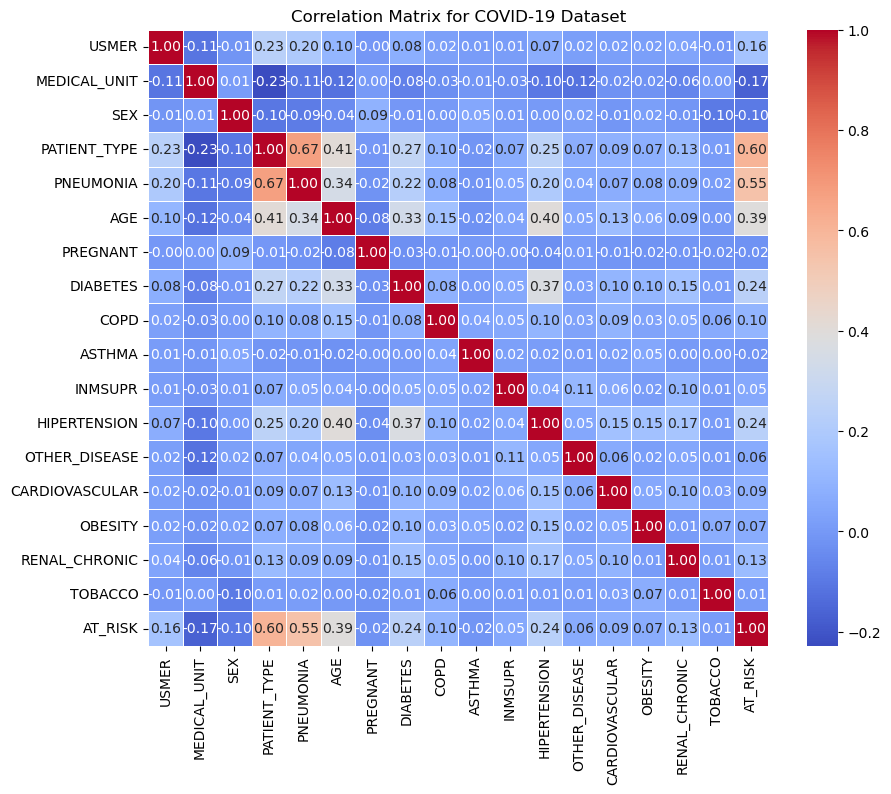

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'covid' DataFrame is ready and includes 'AT_RISK' as one of the columns
# You should check that 'covid' includes the target column for correlation analysis

# Calculate the correlation matrix
corr_matrix = covid.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix for COVID-19 Dataset')
plt.show()


---
# ***Calculate results***

In [3]:
# retuen F-measure (F1-score) for given data and labels
def get_Fmeasure(prediction, labels):

  # Compares the prediction of each object to its label
  true_positive = np.sum((prediction + labels) == 2)
  false_positive = np.sum((labels - prediction) == -1)
  false_negative = np.sum((prediction - labels) == -1)
  positive = np.count_nonzero(labels == 1)
  negative = len(labels)-positive

  # Calculate F-measure
  accuracy = 100*np.sum(prediction == labels)/len(labels)
  recall = true_positive / (true_positive + false_negative)
  precision = true_positive / (true_positive + false_positive)
  eval = 2*(precision * recall) / (precision + recall)
  return eval

---
# ***K-Nearest Neighbors***
The K-Nearest Neighbours is non-linear classifier in which an object is classified to the class most common among its k nearest neighbours in the train set. The hyperparameters for the KNN algorithm are the value of k and the distance function that calculates the distance between two objects. 

In [5]:
from KNearestNeighbor import KNearestNeighbor

# undersampling the train set
atrisk = train[train.AT_RISK==1][:2000]
nonrisk = train[train.AT_RISK==0][:2000]
part_train = pd.concat([nonrisk, atrisk])
train_y = part_train.AT_RISK.to_numpy()
train_x = part_train.drop(columns = ['AT_RISK']).to_numpy()

# set optional knn hyperparameters
k_choices = [1, 3, 5, 9, 13, 17, 23, 31]
dist_func = ["l1", "l2", "linf"]
knn_fmeasures = {}
knn_best_result = 0

for k in k_choices:
    knn_fmeasures[k] = np.zeros(len(dist_func))
    for (i, func) in enumerate(dist_func):
        # create a kNN classifier instance and compute the prediction
        knn_classifier = KNearestNeighbor()
        knn_classifier.train(train_x, train_y)
        pred_y = knn_classifier.predict(validation_x, k=k, dist_func=func) 

        # calculate F-measures and save best model
        knn_fmeasures[k][i] = get_Fmeasure(pred_y, validation_y)
        if knn_fmeasures[k][i] > knn_best_result:
            knn_best_result = knn_fmeasures[k][i]
            knn_best_model = knn_classifier

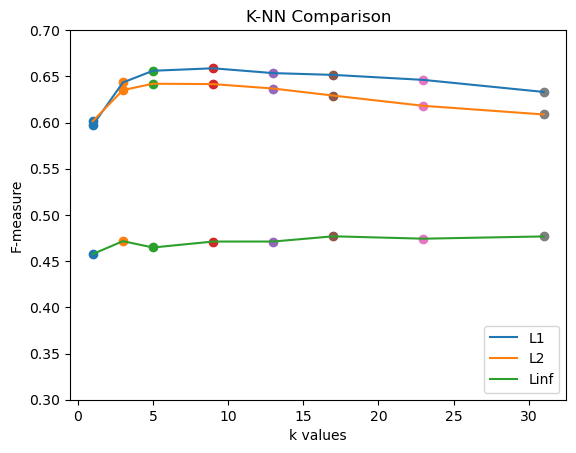

best result for: k = 9, distance function = l1, F-measure = 0.658697


In [6]:
# plot the results
l1, l2, linf = [], [], []
for k in k_choices:
    fmeasures = knn_fmeasures[k]
    plt.scatter([k] * len(fmeasures), fmeasures)
    l1.append(knn_fmeasures[k][0])
    l2.append(knn_fmeasures[k][1])
    linf.append(knn_fmeasures[k][2])

# create line between all k values for each distance function
plt.errorbar(k_choices, l1, label ='L1')
plt.errorbar(k_choices, l2, label ='L2')
plt.errorbar(k_choices, linf, label ='Linf')
plt.legend(loc ='lower right')

plt.title('K-NN Comparison')
plt.xlabel('k values')
plt.ylabel('F-measure')
plt.ylim(0.3, 0.7)
plt.show()

# print best model parameters
print('best result for: k = %d, distance function = %s, F-measure = %f' % (knn_best_model.getK(), knn_best_model.get_func(), knn_best_result))

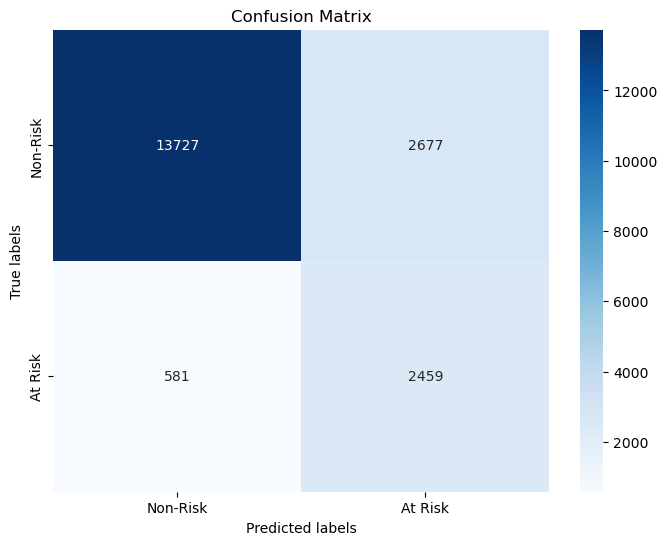

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming knn_best_model is your trained KNearestNeighbor model
# Make predictions on the validation set using the best model
pred_y = knn_best_model.predict(validation_x)

# Calculate confusion matrix
cm = confusion_matrix(validation_y, pred_y)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Risk', 'At Risk'], yticklabels=['Non-Risk', 'At Risk'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
'''
TN FP
FN TP

'''

In [8]:
# Make predictions on the validation set using the best model
pred_y = knn_best_model.predict(validation_x)

# Calculate F-measure
f_measure = get_Fmeasure(pred_y, validation_y)

print("F-measure for the best model:", f_measure)


F-measure for the best model: 0.6015166340508806


In [12]:
def get_evaluation_metrics(prediction, labels):

    # Compares the prediction of each object to its label
    true_positive = np.sum((prediction + labels) == 2)
    false_positive = np.sum((labels - prediction) == -1)
    false_negative = np.sum((prediction - labels) == -1)
    positive = np.count_nonzero(labels == 1)
    negative = len(labels) - positive

    # Calculate evaluation metrics
    accuracy = 100 * np.sum(prediction == labels) / len(labels)
    recall = true_positive / (true_positive + false_negative)
    precision = true_positive / (true_positive + false_positive)
    f_measure = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f_measure

# Make predictions on the validation set using the best model
pred_y = knn_best_model.predict(validation_x)

# Calculate evaluation metrics
accuracy, precision, recall, f_measure = get_evaluation_metrics(pred_y, validation_y)

# Print evaluation metrics
print("Evaluation Metrics for the Best Model:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f_measure)


Evaluation Metrics for the Best Model:
Accuracy: 83.24418843859289
Precision: 0.47877725856697817
Recall: 0.8088815789473685
F-measure: 0.6015166340508806


---
# ***SVM***
SVM is a classifier that separates data points using a linear hyperplane with the largest amount of margin between the two classes in the train set. SVM can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping the inputs into high-dimensional feature spaces.

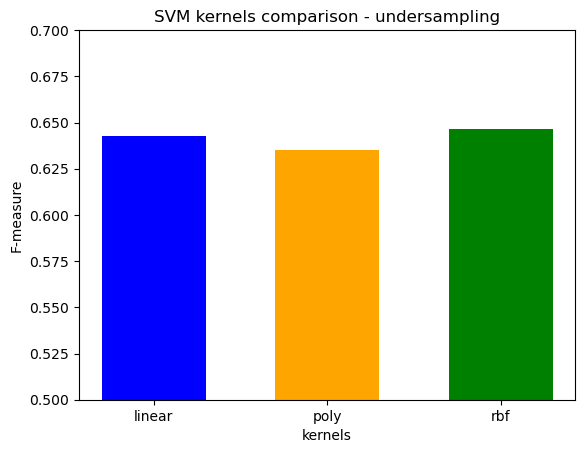

best result for: kernel = rbf, F-measure = 0.646236, Accuracy = 0.843859


In [89]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define a function to compute F-measure, assuming it uses F1 score
def get_Fmeasure(y_true, y_pred):
    return f1_score(y_true, y_pred)

# split the data to x and y
part_train, _ = train_test_split(train, test_size=0.9, shuffle=True)
train_y = part_train.AT_RISK.to_numpy()
train_x = part_train.drop(columns = ['AT_RISK']).to_numpy()

# set all SVM kernel options
kernels = ["linear", "poly", "rbf"]
svm_fmeasures = {}
svm_accuracies = {}  # Track accuracies here
svm_best_result = 0
svm_best_accuracy = 0  # Initialize the best accuracy

for kernel in kernels:
    # create a SVM classifier instance and compute the prediction
    svm_classifier = SVC(kernel=kernel, degree=8, class_weight='balanced')
    svm_classifier.fit(train_x, train_y)
    y_pred = svm_classifier.predict(validation_x)

    # calculate F-measures and save best model
    svm_fmeasures[kernel] = get_Fmeasure(y_pred, validation_y)
    svm_accuracies[kernel] = accuracy_score(validation_y, y_pred)  # Calculate accuracy for each kernel

    # Update best model and accuracy if current one is better
    if svm_fmeasures[kernel] > svm_best_result:
        svm_best_result = svm_fmeasures[kernel]
        svm_best_model = svm_classifier
        svm_best_accuracy = svm_accuracies[kernel]  # Update best accuracy corresponding to the best F-measure

# plot all the results
plt.bar(svm_fmeasures.keys(), svm_fmeasures.values(), color=['blue', 'orange', 'green', 'red'], width=.6)
plt.title('SVM kernels comparison - undersampling')
plt.xlabel('kernels')
plt.ylabel('F-measure')
plt.ylim(0.5, 0.7)
plt.show()

# print best model parameters and the best accuracy
print('best result for: kernel = %s, F-measure = %f, Accuracy = %f' % (svm_best_model.get_params()['kernel'], svm_best_result, svm_best_accuracy))


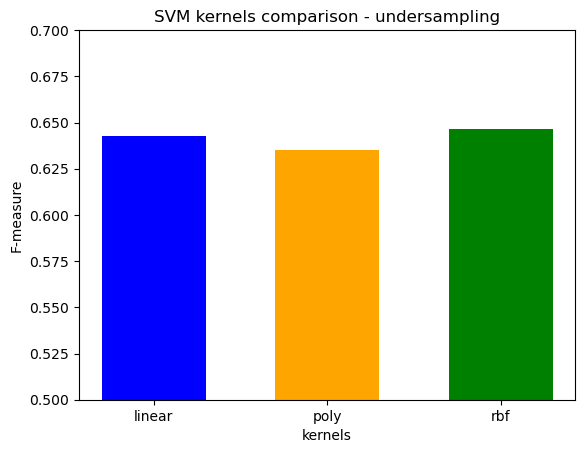

best result for: kernel = rbf, F-measure = 0.646236


In [90]:
# plot all the results
plt.bar(svm_fmeasures.keys(), svm_fmeasures.values(), color=['blue', 'orange', 'green', 'red'], width=.6)
plt.title('SVM kernels comparison - undersampling')
plt.xlabel('kernels')
plt.ylabel('F-measure')
plt.ylim(0.5, 0.7)
plt.show()

# print best model parameters
print('best result for: kernel = %s, F-measure = %f' % (svm_best_model.get_params()['kernel'], svm_best_result))

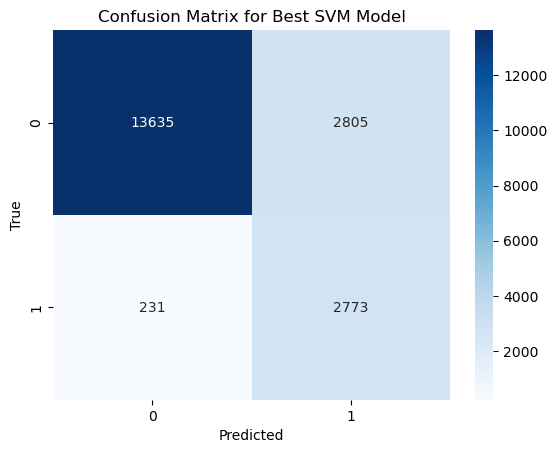

In [91]:
best_y_pred = svm_best_model.predict(validation_x)
cm = confusion_matrix(validation_y, best_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Best SVM Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

---
# ***Decision Tree***
A decision tree is a flowchart-like structure in which each internal node represents a "test" on a feature, each branch represents the outcome of the test, and each leaf node represents a class label. The paths from root to leaf represent classification rules. The decision tree algorithm uses heuristic functions for selecting the splitting criterion that partition data into the best possible manner.

In [41]:
from sklearn.tree import DecisionTreeClassifier

# undersampling the train set
train_y = train.AT_RISK.to_numpy()
train_x = train.drop(columns = ['AT_RISK']).to_numpy()

# set Decision Tree parameters
heuristics = ["entropy", "gini"]
splitters = ["best", "random"]
max_depth = [5, 7, 11, 13, 17]
dt_fmeasures = {}
dt_best_result = 0

for d in max_depth:
    dt_fmeasures[d] = np.zeros(len(heuristics)*len(splitters))
    i=0
    for heuristic, splitter in [(heuristic, splitter) for heuristic in heuristics for splitter in splitters]:
        # create a Decision Tree classifier instance and compute the prediction
        dt_classifier = DecisionTreeClassifier(criterion=heuristic, splitter=splitter, max_depth=d, class_weight='balanced')
        dt_classifier.fit(train_x, train_y)
        y_pred = dt_classifier.predict(validation_x)

        # calculate F-measures and save best model
        dt_fmeasures[d][i] = get_Fmeasure(y_pred, validation_y)
        if dt_fmeasures[d][i] > dt_best_result:
            dt_best_result = dt_fmeasures[d][i]
            dt_best_model = dt_classifier
        i=i+1

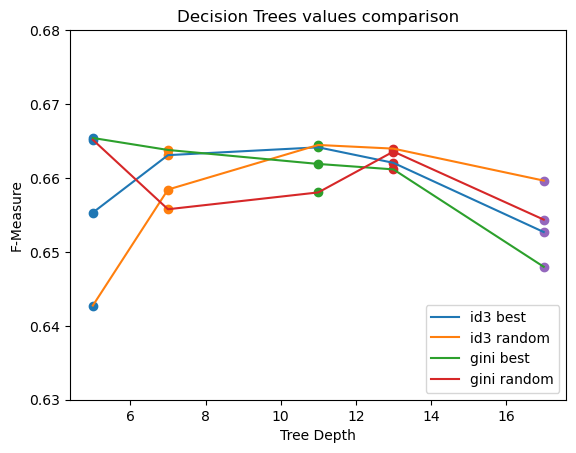

best result for: heuristic = gini, splitter = best, max depth = 5, F-measure = 0.665410


In [44]:
# plot the results
l1, l2, l3, l4 = [], [], [], []
for k in dt_fmeasures.keys():
    fmeasures = dt_fmeasures[k]
    plt.scatter([k] * len(fmeasures), fmeasures)
    l1.append(dt_fmeasures[k][0])
    l2.append(dt_fmeasures[k][1])
    l3.append(dt_fmeasures[k][2])
    l4.append(dt_fmeasures[k][3])

# create line for each of the four models
plt.errorbar(max_depth, l1, label ='id3 best')
plt.errorbar(max_depth, l2, label ='id3 random')
plt.errorbar(max_depth, l3, label ='gini best')
plt.errorbar(max_depth, l4, label ='gini random')
plt.legend(loc ='lower right')
plt.title('Decision Trees values comparison')
plt.xlabel('Tree Depth')
plt.ylabel('F-Measure')
plt.ylim(0.630, 0.68)
plt.show()

# print best model parameters
params = dt_best_model.get_params()
print('best result for: heuristic = %s, splitter = %s, max depth = %d, F-measure = %f' % (params['criterion'], params['splitter'], params['max_depth'], dt_best_result))

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
pred_y = dt_best_model.predict(validation_x)
conf_matrix = confusion_matrix(validation_y, pred_y)
accuracy = accuracy_score(validation_y, pred_y)
precision = precision_score(validation_y, pred_y)
recall = recall_score(validation_y, pred_y)
f1 = f1_score(validation_y, pred_y)
print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Confusion Matrix:
[[13786  2618]
 [  150  2890]]
Accuracy: 0.8576424603990949
Precision: 0.5246913580246914
Recall: 0.9506578947368421
F1 Score: 0.6761815629386991


In [ ]:
cm = conf_matrix
# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Risk', 'At Risk'], yticklabels=['Non-Risk', 'At Risk'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
'''
TN FP
FN TP

'''

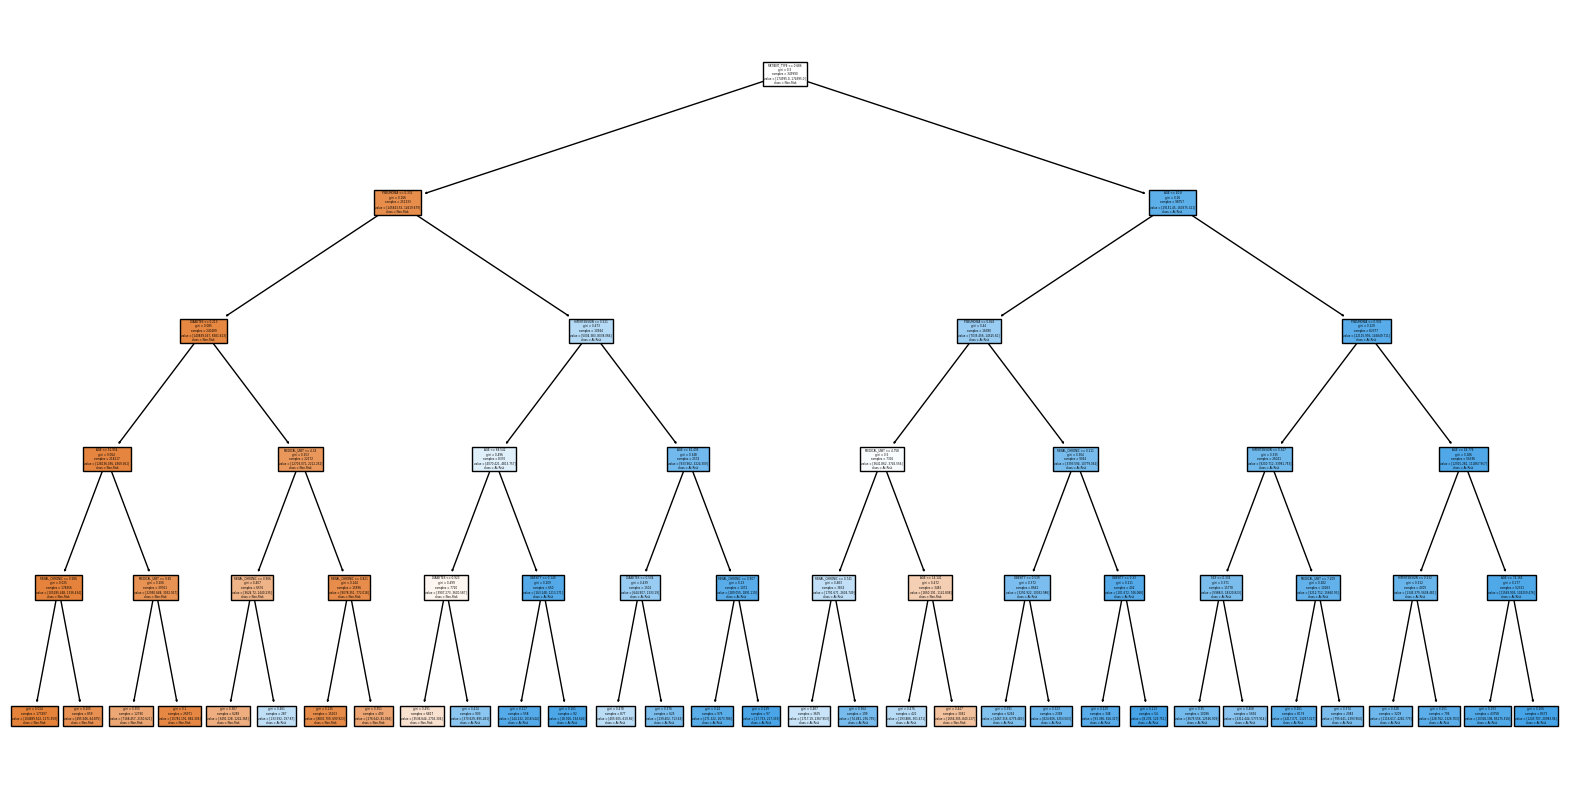

In [14]:
plt.figure(figsize=(20,10))
plot_tree(dt_best_model, filled=True, feature_names=train.columns, class_names=['Non-Risk', 'At-Risk'])
plt.show()


---
# ***Random Forest***
Random forests constructs multitude decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. Random forests generally outperform decision trees

In [8]:
from sklearn.ensemble import RandomForestClassifier

# undersampling the train set
train_y = train.AT_RISK.to_numpy()
train_x = train.drop(columns = ['AT_RISK']).to_numpy()

# set Random Forest parameters
heuristics = ["entropy", "gini"]
max_depth = [3, 5, 7, 11, 13, 15, 17]
rf_fmeasures = {}
rf_best_result = 0
for j in range(5):
    for d in max_depth:
        rf_fmeasures[d] = np.zeros(len(heuristics))
        for (i, heuristic) in enumerate(heuristics):
            # create a Random Forest classifier instance and compute the prediction
            rf_classifier = RandomForestClassifier(n_estimators=100, criterion=heuristic, max_depth=d, class_weight='balanced')
            rf_classifier.fit(train_x, train_y)
            y_pred = rf_classifier.predict(validation_x)

            # calculate F-measures and save best model
            rf_fmeasures[d][i] = get_Fmeasure(y_pred, validation_y)
            if rf_fmeasures[d][i] > rf_best_result:
                rf_best_result = rf_fmeasures[d][i]
                rf_best_model = rf_classifier   

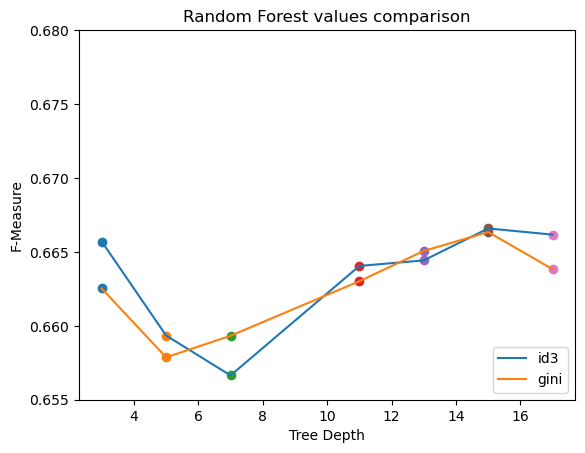

best result for: heuristic = gini, max depth = 3, F-measure = 0.670401


In [10]:
# plot the results
import matplotlib.pyplot as plt

l1, l2 = [], []
for k in rf_fmeasures.keys():
    fmeasures = rf_fmeasures[k]
    plt.scatter([k] * len(fmeasures), fmeasures)
    l1.append(rf_fmeasures[k][0])
    l2.append(rf_fmeasures[k][1])

# create line for each  models
plt.errorbar(max_depth, l1, label ='id3')
plt.errorbar(max_depth, l2, label ='gini')
plt.legend(loc ='lower right')
plt.title('Random Forest values comparison')
plt.xlabel('Tree Depth')
plt.ylabel('F-Measure')
plt.ylim(0.655, 0.68)
plt.show()

# print best model parameters
params = rf_best_model.get_params()
print('best result for: heuristic = %s, max depth = %d, F-measure = %f' % (params['criterion'], params['max_depth'], rf_best_result))

Confusion Matrix:
[[14103  2399]
 [  249  2693]]
Accuracy: 0.8638140300349723
Precision: 0.5288688138256088
Recall: 0.9153636981645139
F1 Score: 0.6704007966143888


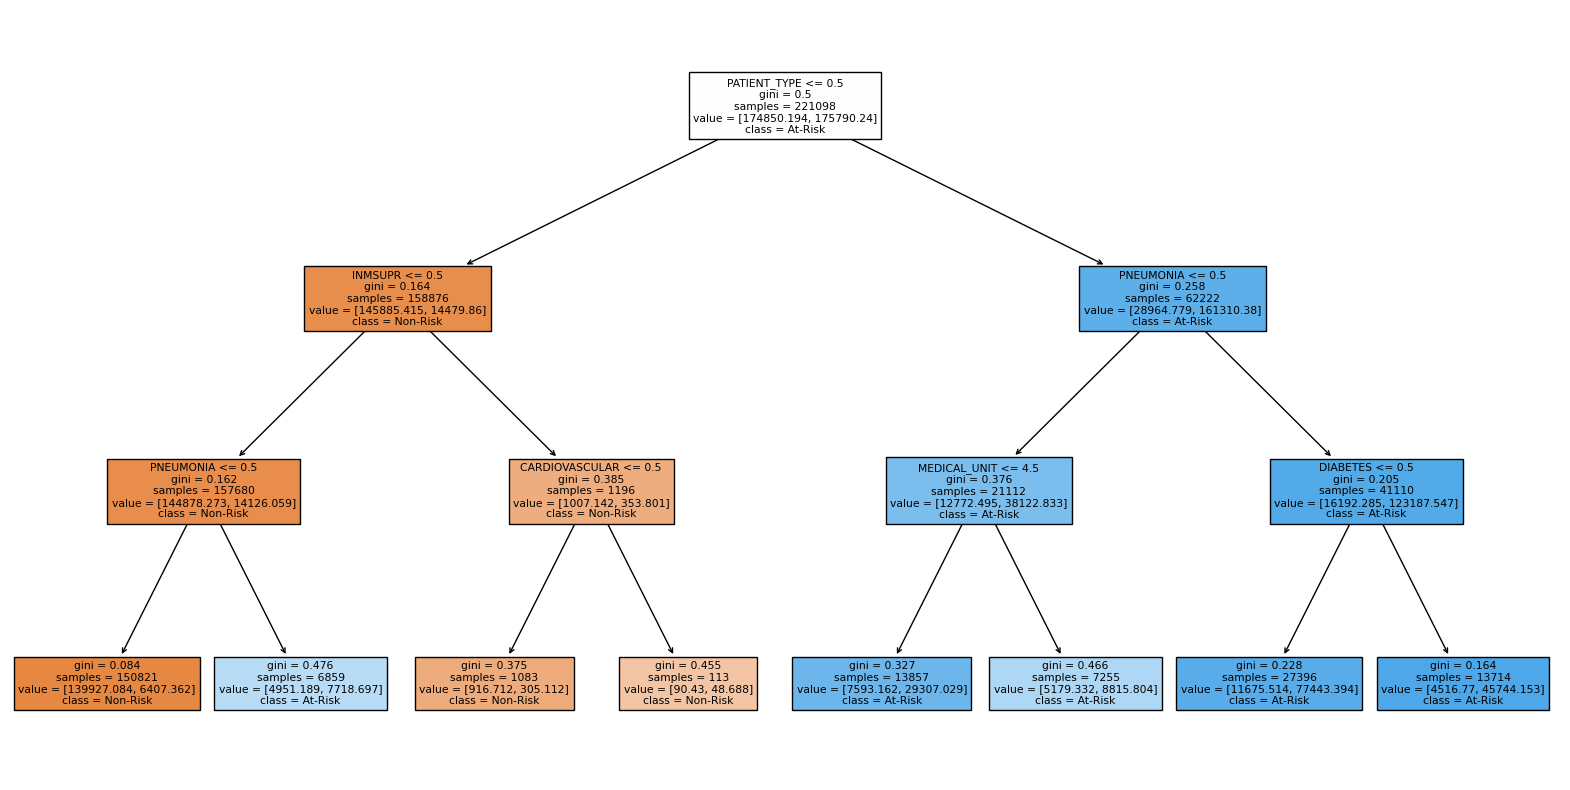

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
pred_y = rf_best_model.predict(validation_x)
conf_matrix = confusion_matrix(validation_y, pred_y)
accuracy = accuracy_score(validation_y, pred_y)
precision = precision_score(validation_y, pred_y)
recall = recall_score(validation_y, pred_y)
f1 = f1_score(validation_y, pred_y)
print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Choose one tree from the Random Forest (e.g., the first tree)
chosen_tree = rf_best_model.estimators_[0]

# Visualize the chosen tree
plt.figure(figsize=(20,10))
plot_tree(chosen_tree, filled=True, feature_names=train.columns, class_names=['Non-Risk', 'At-Risk'])
plt.show()


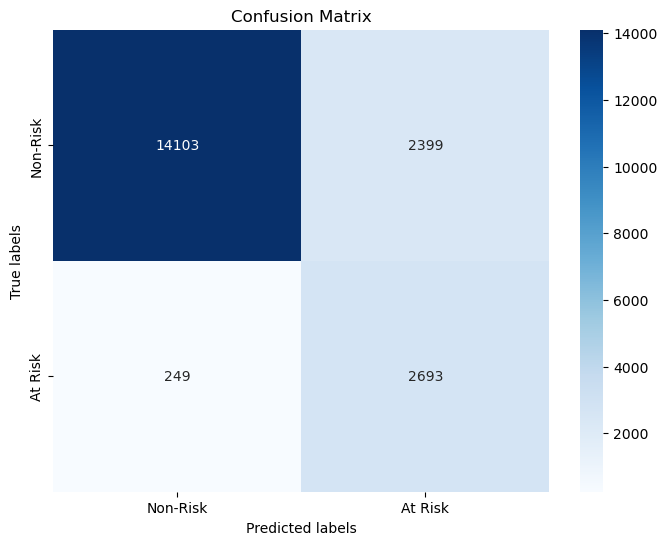

In [15]:
# Plot confusion matrix using seaborn heatmap
import seaborn as sns
plt.figure(figsize=(8, 6))
cm=conf_matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Risk', 'At Risk'], yticklabels=['Non-Risk', 'At Risk'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

---
# ***Multilayer Perceptron***
An MLP model consists of at least three layers of nodes: an input layer, a hidden layer, and an output layer. Except for the input nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called backpropagation for training.

In [20]:
from sklearn.neural_network import MLPClassifier

# undersampling the train set
atrisk = train[train.AT_RISK==1][:20000]
nonrisk = train[train.AT_RISK==0][:20000]
part_train = (pd.concat([nonrisk, atrisk])).sample(frac = 1)
train_y = part_train.AT_RISK.to_numpy()
train_x = part_train.drop(columns = ['AT_RISK']).to_numpy()

# set MLP parameters
layers = [(100,50,30,10,5), (15,10,5,10,15), (20,20,20,20), (10)]
optimizers = ['adam', 'sgd']
mlp_fmeasures = {}
mlp_best_result = 0

for (i, opt) in  enumerate(optimizers):
    mlp_fmeasures[i] = np.zeros(len(layers))
    for (j, layer) in enumerate(layers):
        # create a Logistic Regression classifier instance and compute the prediction
        mlp_classifier = MLPClassifier(hidden_layer_sizes = layer,
                                          solver = opt,
                                          learning_rate ='adaptive',
                                          max_iter = 5000)
        mlp_classifier.fit(train_x, train_y)
        y_pred = mlp_classifier.predict(validation_x)

        # calculate F-measures and save best model
        mlp_fmeasures[i][j] = get_Fmeasure(y_pred, validation_y)
        if mlp_fmeasures[i][j] > mlp_best_result:
            mlp_best_result = mlp_fmeasures[i][j]
            mlp_best_model = mlp_classifier

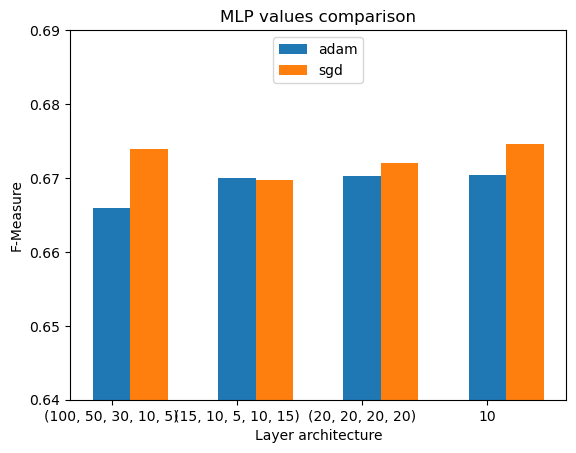

best result for: optimizer = sgd, layer = 10, F-measure = 0.674541


In [21]:
# plot the results
width = 0
for i in mlp_fmeasures.keys():
    fmeasures = mlp_fmeasures[i]
    plt.bar(np.arange(len(fmeasures))+width, fmeasures, width=0.3, label=optimizers[i])
    width += 0.3

plt.xticks(range(len(layers)), layers)
plt.legend(loc ='upper center')
plt.title('MLP values comparison')
plt.xlabel('Layer architecture')
plt.ylabel('F-Measure')
plt.ylim(0.64, 0.69)
plt.show()

# print best model parameters
params = mlp_best_model.get_params()
print('best result for: optimizer = %s, layer = %s, F-measure = %f' % (params['solver'], params['hidden_layer_sizes'], mlp_best_result))

In [22]:
# Get predictions on the validation set using the best MLP model
pred_y_mlp = mlp_best_model.predict(validation_x)

# Calculate evaluation metrics
conf_matrix_mlp = confusion_matrix(validation_y, pred_y_mlp)
accuracy_mlp = accuracy_score(validation_y, pred_y_mlp)
precision_mlp = precision_score(validation_y, pred_y_mlp)
recall_mlp = recall_score(validation_y, pred_y_mlp)
f1_mlp = f1_score(validation_y, pred_y_mlp)

# Print evaluation metrics
print("Confusion Matrix for MLP:")
print(conf_matrix_mlp)
print("Accuracy for MLP:", accuracy_mlp)
print("Precision for MLP:", precision_mlp)
print("Recall for MLP:", recall_mlp)
print("F1 Score for MLP:", f1_mlp)


Confusion Matrix for MLP:
[[13777  2627]
 [  156  2884]]
Accuracy for MLP: 0.8568710141946102
Precision for MLP: 0.5233170023589185
Recall for MLP: 0.9486842105263158
F1 Score for MLP: 0.6745409893579698


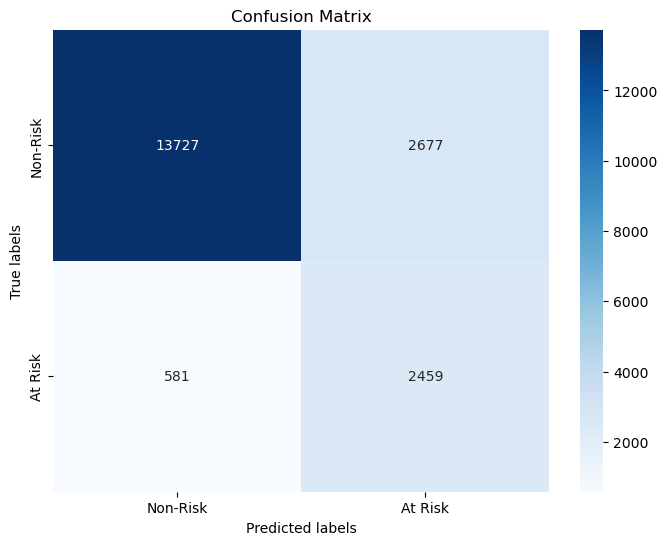

In [23]:
# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Risk', 'At Risk'], yticklabels=['Non-Risk', 'At Risk'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


---
# ***Final Evaluation***
runnig the best models from each technique on the test set.

In [35]:
# ran the best models from each technique on the test set
knn_pred = knn_best_model.predict(test_x)
#svm_pred = svm_best_model.predict(test_x)
dt_pred = dt_best_model.predict(test_x)
rf_pred = rf_best_model.predict(test_x)
mlp_pred = mlp_best_model.predict(test_x)

# get results
final_fmeasures = {}
final_fmeasures['knn'] = get_Fmeasure(knn_pred, test_y)
#final_fmeasures['svm'] = get_Fmeasure(svm_pred, test_y)
final_fmeasures['decision tree'] = get_Fmeasure(dt_pred, test_y)
final_fmeasures['rand forest'] = get_Fmeasure(rf_pred, test_y)
final_fmeasures['mlp'] = get_Fmeasure(mlp_pred, test_y)

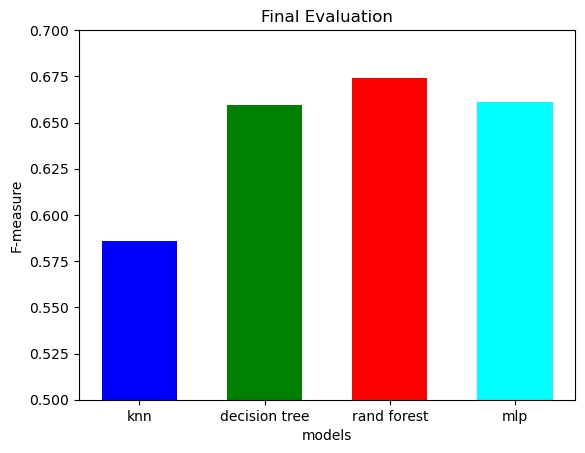


               precision    recall  f1-score   support

           0       0.98      0.85      0.91     16453
           1       0.53      0.92      0.67      2991

    accuracy                           0.86     19444
   macro avg       0.76      0.89      0.79     19444
weighted avg       0.91      0.86      0.88     19444



In [36]:
from sklearn.metrics import classification_report

# plot all the results
plt.bar(final_fmeasures.keys(), final_fmeasures.values(), color=['blue', 'green', 'red', 'cyan'], width=.6)
plt.title('Final Evaluation')
plt.xlabel('models')
plt.ylabel('F-measure')
plt.ylim(0.5, 0.7)
plt.show()

# print best model results
print('\n', classification_report(test_y, rf_pred))

In [54]:
# Given input data
input_data = [0,1,1,0,1,65,0,0,0,0,0,1,0,0,0,0,0] 

# Assuming the data needs to be in the form of a 2D array for sklearn
input_data_reshaped = np.array(input_data).reshape(1, -1)

# Predicting with the best model (assuming 'rf_best_model' is the trained RandomForestClassifier instance)
risk_prediction = rf_best_model.predict(input_data_reshaped)

# Output the prediction

predicted_risk = 'At Risk' if risk_prediction[0] == 1 else 'No Risk'
print('The patient is:', predicted_risk)


The patient is: At Risk


In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install xgboost

import xgboost as xgb
train_y = train.AT_RISK.to_numpy()
train_x = train.drop(columns = ['AT_RISK']).to_numpy()

# Initialize and train the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(train_x, train_y, eval_set=[(validation_x, validation_y)], early_stopping_rounds=10, verbose=True)

# Evaluate the model
validation_score = xgb_model.score(validation_x, validation_y)
test_score = xgb_model.score(test_x, test_y)

print(f"Validation Accuracy: {validation_score}")
print(f"Test Accuracy: {test_score}")


c:\Users\zaidk\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.34049
[1]	validation_0-logloss:0.29543
[2]	validation_0-logloss:0.26791
[3]	validation_0-logloss:0.25016
[4]	validation_0-logloss:0.23811
[5]	validation_0-logloss:0.22998
[6]	validation_0-logloss:0.22446
[7]	validation_0-logloss:0.22048
[8]	validation_0-logloss:0.21755
[9]	validation_0-logloss:0.21556
[10]	validation_0-logloss:0.21419
[11]	validation_0-logloss:0.21313
[12]	validation_0-logloss:0.21243
[13]	validation_0-logloss:0.21197
[14]	validation_0-logloss:0.21176
[15]	validation_0-logloss:0.21151
[16]	validation_0-logloss:0.21135
[17]	validation_0-logloss:0.21116
[18]	validation_0-logloss:0.21102
[19]	validation_0-logloss:0.21100
[20]	validation_0-logloss:0.21095
[21]	validation_0-logloss:0.21091
[22]	validation_0-logloss:0.21086
[23]	validation_0-logloss:0.21088
[24]	validation_0-logloss:0.21087
[25]	validation_0-logloss:0.21088
[26]	validation_0-logloss:0.21093
[27]	validation_0-logloss:0.21094
[28]	validation_0-logloss:0.21092
[29]	validation_0-loglos

In [59]:
from sklearn.metrics import confusion_matrix, f1_score

# Evaluate the model on the validation set
validation_preds = xgb_model.predict(validation_x)
validation_conf_matrix = confusion_matrix(validation_y, validation_preds)
validation_f1 = f1_score(validation_y, validation_preds)

# Evaluate the model on the test set
test_preds = xgb_model.predict(test_x)
test_conf_matrix = confusion_matrix(test_y, test_preds)
test_f1 = f1_score(test_y, test_preds)

print(f"Validation Confusion Matrix:\n{validation_conf_matrix}")
print(f"Validation F1 Score: {validation_f1}")
print(f"Test Confusion Matrix:\n{test_conf_matrix}")
print(f"Test F1 Score: {test_f1}")


Validation Confusion Matrix:
[[15368  1072]
 [ 1027  1977]]
Validation F1 Score: 0.6532298034032711
Test Confusion Matrix:
[[15379  1062]
 [ 1069  1934]]
Test F1 Score: 0.6447741290215036


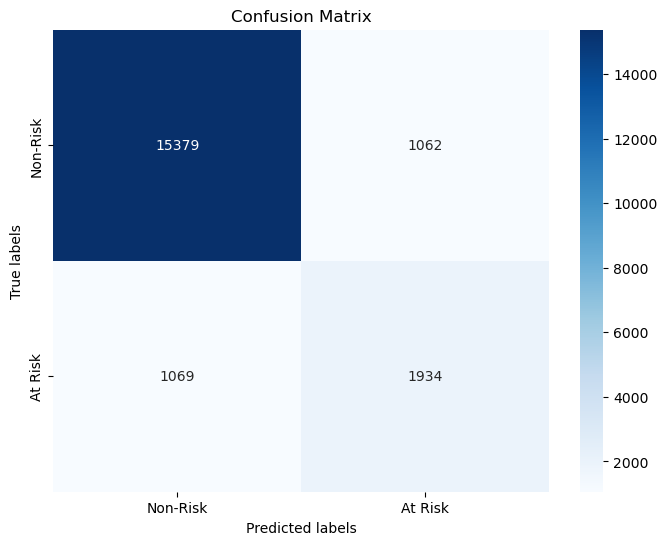

In [60]:
# Plot confusion matrix using seaborn heatmap
import seaborn as sns
plt.figure(figsize=(8, 6))
cm=test_conf_matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Risk', 'At Risk'], yticklabels=['Non-Risk', 'At Risk'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [62]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


# Predictions for validation set (to train the meta-model)
rf_val_predictions = rf_best_model.predict_proba(validation_x)[:, 1]  # Get probabilities for the positive class
xgb_val_predictions = xgb_model.predict_proba(validation_x)[:, 1]  # Ditto for XGBoost

# Stack predictions to form new features
stacked_val_predictions = np.column_stack((rf_val_predictions, xgb_val_predictions))

# Predictions for test set (to evaluate the ensemble)
rf_test_predictions = rf_best_model.predict_proba(test_x)[:, 1]
xgb_test_predictions = xgb_model.predict_proba(test_x)[:, 1]
stacked_test_predictions = np.column_stack((rf_test_predictions, xgb_test_predictions))

# Meta-model: Logistic Regression is a common choice for binary outcomes
meta_model = LogisticRegression()
meta_model.fit(stacked_val_predictions, validation_y)  # Train on stacked predictions from validation set

# Evaluate ensemble on test data
ensemble_accuracy = meta_model.score(stacked_test_predictions, test_y)
print(f"Ensemble Test Accuracy: {ensemble_accuracy}")


Ensemble Test Accuracy: 0.8874717136391689


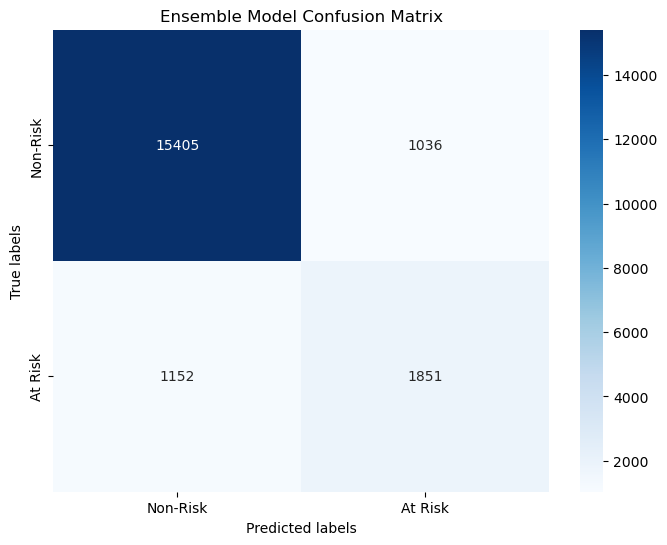

Ensemble Model F1 Score: 0.628522920203735


In [64]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class labels on the test set using the meta-model
ensemble_test_predictions = meta_model.predict(stacked_test_predictions)

# Calculate confusion matrix
cm = confusion_matrix(test_y, ensemble_test_predictions)

# Calculate F1 score
f1 = f1_score(test_y, ensemble_test_predictions)

# Optionally, plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Risk', 'At Risk'], yticklabels=['Non-Risk', 'At Risk'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Ensemble Model Confusion Matrix')
plt.show()

# Print F1 score
print(f"Ensemble Model F1 Score: {f1}")


In [20]:
# Initialize and train XGBoost
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
xgb_model.fit(train_x, train_y, eval_set=[(validation_x, validation_y)], early_stopping_rounds=10, verbose=True)

# Feature importances
feature_importances = xgb_model.feature_importances_
feature_names = train.drop(columns=['AT_RISK']).columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
important_features = importance_df.sort_values(by='Importance', ascending=False)

print(important_features)

# Select top N features
top_features = important_features.head()['Feature']

# Subset the training and validation data to top N features
train_x_selected = train[top_features].to_numpy()
validation_x_selected = validation[top_features].to_numpy()

# Retrain XGBoost with selected features
xgb_selected_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
xgb_selected_model.fit(train_x_selected, train_y, eval_set=[(validation_x_selected, validation_y)], early_stopping_rounds=10, verbose=True)

# Evaluate the new model
new_validation_score = xgb_selected_model.score(validation_x_selected, validation_y)
print(f"New Validation Accuracy: {new_validation_score}")


c:\Users\zaidk\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.33877
[1]	validation_0-logloss:0.29414
[2]	validation_0-logloss:0.26700
[3]	validation_0-logloss:0.24935
[4]	validation_0-logloss:0.23755
[5]	validation_0-logloss:0.22944
[6]	validation_0-logloss:0.22372
[7]	validation_0-logloss:0.21980
[8]	validation_0-logloss:0.21693
[9]	validation_0-logloss:0.21499
[10]	validation_0-logloss:0.21349
[11]	validation_0-logloss:0.21259
[12]	validation_0-logloss:0.21184
[13]	validation_0-logloss:0.21135
[14]	validation_0-logloss:0.21093
[15]	validation_0-logloss:0.21071
[16]	validation_0-logloss:0.21039
[17]	validation_0-logloss:0.21032
[18]	validation_0-logloss:0.21020
[19]	validation_0-logloss:0.21020
[20]	validation_0-logloss:0.21015
[21]	validation_0-logloss:0.21015
[22]	validation_0-logloss:0.21010
[23]	validation_0-logloss:0.21008
[24]	validation_0-logloss:0.21010
[25]	validation_0-logloss:0.21013
[26]	validation_0-logloss:0.21017
[27]	validation_0-logloss:0.21013
[28]	validation_0-logloss:0.21018
[29]	validation_0-loglos

c:\Users\zaidk\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.33877
[1]	validation_0-logloss:0.29416
[2]	validation_0-logloss:0.26700
[3]	validation_0-logloss:0.24934
[4]	validation_0-logloss:0.23761
[5]	validation_0-logloss:0.22942
[6]	validation_0-logloss:0.22389
[7]	validation_0-logloss:0.21989
[8]	validation_0-logloss:0.21705
[9]	validation_0-logloss:0.21516
[10]	validation_0-logloss:0.21378
[11]	validation_0-logloss:0.21280
[12]	validation_0-logloss:0.21214
[13]	validation_0-logloss:0.21162
[14]	validation_0-logloss:0.21126
[15]	validation_0-logloss:0.21110
[16]	validation_0-logloss:0.21096
[17]	validation_0-logloss:0.21091
[18]	validation_0-logloss:0.21070
[19]	validation_0-logloss:0.21064
[20]	validation_0-logloss:0.21065
[21]	validation_0-logloss:0.21062
[22]	validation_0-logloss:0.21062
[23]	validation_0-logloss:0.21062
[24]	validation_0-logloss:0.21066
[25]	validation_0-logloss:0.21070
[26]	validation_0-logloss:0.21069
[27]	validation_0-logloss:0.21070
[28]	validation_0-logloss:0.21071
[29]	validation_0-loglos

In [21]:
print(important_features)

           Feature  Importance
3     PATIENT_TYPE    0.904659
4        PNEUMONIA    0.056155
5              AGE    0.011417
1     MEDICAL_UNIT    0.005385
15   RENAL_CHRONIC    0.003436
7         DIABETES    0.003385
2              SEX    0.003313
14         OBESITY    0.002397
11    HIPERTENSION    0.002187
0            USMER    0.001418
12   OTHER_DISEASE    0.001137
10         INMSUPR    0.001099
8             COPD    0.000872
9           ASTHMA    0.000852
6         PREGNANT    0.000791
16         TOBACCO    0.000762
13  CARDIOVASCULAR    0.000735


In [26]:
!pip install lightgbm



     ---------------------------------------- 1.3/1.3 MB 2.7 MB/s eta 0:00:00
     -------------------------------------- 101.1/101.1 MB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 47.1/47.1 kB 2.3 MB/s eta 0:00:00


In [69]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Parameters for LightGBM
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1
}

# Setup 5-fold stratified cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_accuracies = []
test_accuracies = []
conf_matrices = []
f1_scores = []

for train_index, test_index in kf.split(X_train, y_train):
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Create LightGBM datasets
    train_data_fold = lgb.Dataset(X_train_fold, label=y_train_fold)
    valid_data_fold = lgb.Dataset(X_valid_fold, label=y_valid_fold)
    
    # Train the model with early stopping
    clf = lgb.train(
        params, train_data_fold, valid_sets=[valid_data_fold]
    )
    
    # Make predictions and evaluate on the training and validation sets
    y_train_pred = clf.predict(X_train_fold, num_iteration=clf.best_iteration)
    y_train_pred = (y_train_pred >= 0.5).astype(int)
    y_valid_pred = clf.predict(X_valid_fold, num_iteration=clf.best_iteration)
    y_valid_pred = (y_valid_pred >= 0.5).astype(int)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(y_train_fold, y_train_pred)
    valid_accuracy = accuracy_score(y_valid_fold, y_valid_pred)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(valid_accuracy)
    
    # Calculate confusion matrix and F1 score
    cm = confusion_matrix(y_valid_fold, y_valid_pred)
    conf_matrices.append(cm)
    f1 = f1_score(y_valid_fold, y_valid_pred)
    f1_scores.append(f1)

# Print average accuracies, confusion matrix, and F1 score across all folds
print(f"Average Train Accuracy: {np.mean(train_accuracies)}")
print(f"Average Test Accuracy: {np.mean(test_accuracies)}")
print("Average Confusion Matrix:\n", np.mean(conf_matrices, axis=0))
print(f"Average F1 Score: {np.mean(f1_scores)}")


Average Train Accuracy: 0.8939862567501929
Average Test Accuracy: 0.8931912340352582
Average Confusion Matrix:
 [[55450.6  3753. ]
 [ 3723.4  7071. ]]
Average F1 Score: 0.6541435692891644


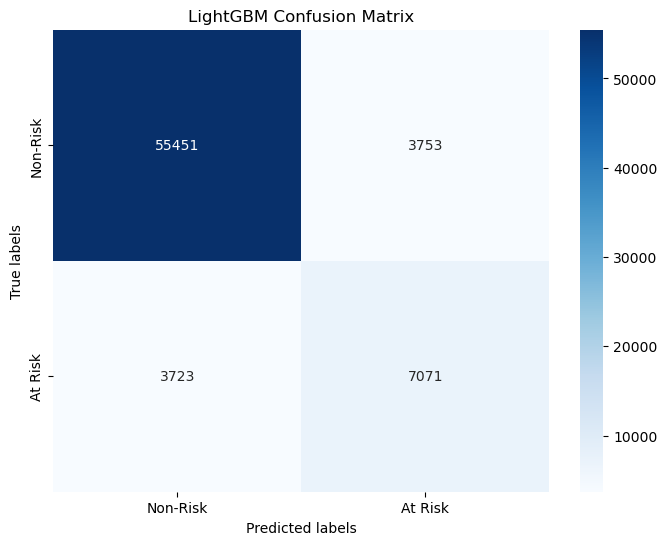

In [77]:
cm=np.mean(conf_matrices, axis=0)
cm = np.round(cm).astype(int) 
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Risk', 'At Risk'], yticklabels=['Non-Risk', 'At Risk'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('LightGBM Confusion Matrix')
plt.show()


In [56]:
import numpy as np
import lightgbm as lgb

# Given input data#usmer 340
input_data = [1,3,0,1,1,90,0,0,0,0,0,1,0,0,0,0,0]

# Assuming the data needs to be in the form of a 2D array for sklearn
input_data_reshaped = np.array(input_data).reshape(1, -1)

# Ensure clf is the trained LightGBM model from previous steps
# Predicting with the trained LightGBM model
risk_prediction = clf.predict(input_data_reshaped, num_iteration=clf.best_iteration)

# Convert probability to class label (assuming binary classification with a threshold of 0.5)
predicted_risk = 'At Risk' if risk_prediction[0] >= 0.5 else 'No Risk'
print('The patient is:', predicted_risk)


The patient is: At Risk


In [58]:
import numpy as np
import lightgbm as lgb

# Given input data#usmer 340
input_data = [1,3,0,1,1,90,0,0,0,0,0,1,0,0,0,0,0]

# Assuming the data needs to be in the form of a 2D array for sklearn
input_data_reshaped = np.array(input_data).reshape(1, -1)

# Ensure clf is the trained LightGBM model from previous steps
# Predicting with the trained LightGBM model
risk_prediction = xgb_model.predict(input_data_reshaped)

# Convert probability to class label (assuming binary classification with a threshold of 0.5)
predicted_risk = 'At Risk' if risk_prediction[0] >= 0.5 else 'No Risk'
print('The patient is:', predicted_risk)


The patient is: At Risk


In [92]:
#Comparitive analysis 
import plotly.graph_objects as go

# Model names and their accuracies
models = ['K-Means', 'SVM', 'MLP','Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM', 'Ensemble']
accuracies = [83.2, 84.2, 85.6 ,85.76, 86.381, 89.04, 89.31, 88.747]

# Combine the models and accuracies, sort them by accuracy, then unzip into separate lists
sorted_data = sorted(zip(models, accuracies), key=lambda x: x[1])
sorted_models, sorted_accuracies = zip(*sorted_data)

# Create the bar chart
fig = go.Figure(data=[go.Bar(
    x=sorted_models,
    y=sorted_accuracies,
    text=sorted_accuracies,
    textposition='auto',
    marker_color='indianred'  # Set the color of the bars
)])

# Update the layout for a better visual representation
fig.update_layout(
    title='Comparison Analysis of Model Accuracies',
    xaxis_title='Models',
    yaxis_title='Accuracy (%)',
    yaxis=dict(range=[80, 90])  # Adjust the range to make differences more notable
)

# Show the plot
fig.show()


In [78]:
import nltk
from nltk.tokenize import word_tokenize
import re

In [79]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zaidk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [115]:
def extract_parameters(terms, sentence):
    # Initialize a dictionary to store the parameters
    parameters = {term.lower(): 0 for term in terms}
    
    # Tokenize the sentence into words
    words = sentence.lower().split()
    
    # Iterate over the words in the sentence
    for i, word in enumerate(words):
        # If the word is a term, update its value
        if word in parameters:
            # If the term is "age" or "cholesterol", the next word should be the value
            if (word == "age" or word == "cholesterol") and i < len(words) - 1 and words[i + 2].isdigit():
                parameters[word] = int(words[i + 2])
            # If the previous word is "not" or "don't", the term is negated
            elif i > 0 and words[i - 2] in ["not", "don't"]:
                parameters[word] = 0
            else:
                parameters[word] = 1
    
    # Convert the parameters to a list in the same order as the terms
    parameters_list = [parameters[term.lower()] for term in terms]
    
    return parameters_list

In [116]:
terms = ["USMER", "MEDICAL_UNIT", "SEX", "PATIENT_TYPE", "PNEUMONIA", "AGE", "PREGNANT", "DIABETES", "COPD", "ASTHMA", "INMSUPR", "HIPERTENSION", "OTHER_DISEASE", "CARDIOVASCULAR", "OBESITY", "RENAL_CHRONIC", "TOBACCO"]
sentence = "Hi doctor my age is 16 having pneumonia and am pregnant"

# Call the function and print the result
print(extract_parameters(terms, sentence))

[0, 0, 0, 0, 1, 16, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [117]:
import numpy as np
import lightgbm as lgb

# Given input data#usmer 340
#input_data = [1,3,0,1,1,90,0,0,0,0,0,1,0,0,0,0,0]
input_data=extract_parameters(terms, sentence)

# Assuming the data needs to be in the form of a 2D array for sklearn
input_data_reshaped = np.array(input_data).reshape(1, -1)

# Ensure clf is the trained LightGBM model from previous steps
# Predicting with the trained LightGBM model
risk_prediction = clf.predict(input_data_reshaped,num_iteration=clf.best_iteration)

# Convert probability to class label (assuming binary classification with a threshold of 0.5)
predicted_risk = 'At Risk' if risk_prediction[0] >= 0.5 else 'No Risk'
print('The patient is:', predicted_risk)

The patient is: No Risk


In [106]:

import numpy as np
import lightgbm as lgb

# Given input data#usmer 340
#input_data = [1,3,0,1,1,90,0,0,0,0,0,1,0,0,0,0,0]
input_data=extract_parameters(terms, sentence)

# Assuming the data needs to be in the form of a 2D array for sklearn
input_data_reshaped = np.array(input_data).reshape(1, -1)

# Ensure clf is the trained LightGBM model from previous steps
# Predicting with the trained LightGBM model
risk_prediction = xgb_model.predict(input_data_reshaped)

# Convert probability to class label (assuming binary classification with a threshold of 0.5)
predicted_risk = 'At Risk' if risk_prediction[0] >= 0.5 else 'No Risk'
print('The patient is:', predicted_risk)



The patient is: No Risk


In [107]:
import numpy as np
import lightgbm as lgb

# Given input data#col with row 340
#input_data = [1,3,0,1,1,90,0,0,0,0,0,1,0,0,0,0,0]
input_data= [1,3,0,1,1,90,0,0,0,0,0,1,0,0,0,0,0]

# Assuming the data needs to be in the form of a 2D array for sklearn
input_data_reshaped = np.array(input_data).reshape(1, -1)

# Ensure clf is the trained LightGBM model from previous steps
# Predicting with the trained LightGBM model
risk_prediction = clf.predict(input_data_reshaped,num_iteration=clf.best_iteration)

# Convert probability to class label (assuming binary classification with a threshold of 0.5)
predicted_risk = 'At Risk' if risk_prediction[0] >= 0.5 else 'No Risk'
print('The patient is:', predicted_risk)

The patient is: At Risk
